# **Workshop: Quantum Computing 101 Part II**

The second part of the workshop will focus on a hybrid quantum algorithm, the variational quantum eigensolver (VQE), giving a general description of how the algorithm works. We will implement the VQE algorithm for the Hydrogen molecule $H_2$. 

The $H_2$ system is one of the smallest systems one can imagine to begin using VQE with. The $H_2$ molecule is so small that it can be solved analytically and also extremely fast on your laptop. 

For this notebook, we will be following the work reported in [O'Malley etal 2015, *Scalable Quantum Simulation of Molecular Energies*, arXiv:1512.06860v2](https://arxiv.org/abs/1512.06860). The following figure given in the article summarizes the entire setup:

<img src="img/omalley-etal-2016-vqe.png" alt="VQE circuit. Source arXiv 1512.06860v2" title="VQE circuit. Source arXiv 1512.06860v2" style="width: 700px;"/>

Fig. 1. The variational quantum eigensolver circuit and hardware. Source: <a href="https://arxiv.org/abs/1512.06860">arXiv:1512.06860v2</a>. 

The right part of the figure describes our "qubit Hamiltonian" of $H_2$. The top part of the figure describes the physical pulses with timings. 


## **VQE - In a nutshell** 

- Prepare some quantum state using a so-called variational form (ansatz)
- Gates in the ansatz have free parameters
- For each value of the parameters the resulting state has some mean energy
- Find the ground state variationally, that is, minimising over the parameters

<img src="img/vqe-nutshell.png" alt="VQE nutshell. Source Algorithmiq" style="width: 700px;"/>

Source: Algorithmiq


The variational principle: 

$$ \langle E \rangle = \langle \psi (\vec{\theta}) | \hat{H} | \psi(\vec{\theta}) \rangle \geq E_{ground} $$


Firstly we will write our quantum circuit:

1. Prepare our initial state
2. Create and applying our parametrized ansatz using parameterized gates
3. Measure our expectation values 

Then we apply our classic part which consists of

1. Calculating the energy 
2. Using a classical optimizer to suggest new parameters $\theta$.


We will do this first for the simulator to see how the algorithm works, and then run a simplified version on the real quantum computer. 

Let's first import some libraries and setup the backend connection

In [23]:
import numpy as np
from iqm.qiskit_iqm import IQMFakeAdonis
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, execute
from qiskit.circuit import Parameter
from qiskit.compiler import transpile
from qiskit_aer import Aer

In [25]:
# provider = IQMProvider("https://qc.vtt.fi/helmi/cocos")
# backend_helmi = provider.get_backend()

backend_sim = Aer.get_backend("aer_simulator")

fake_backend = IQMFakeAdonis()

In [26]:
def create_ansatz_circuit(qreg, creg, parameter):
    """
    Create H2 ansatz circuit given in O'Malley etal 2015.

    args
        qreg           - qubits
        creg           - classical bits
        parameter      - parameter for parameterized circuit

    returns
        ansatz_circuit - a parameterized circuit
    """
    ansatz_circuit = QuantumCircuit(qreg, creg)

    # H2 circuit
    # 1 - create HF reference state
    ansatz_circuit.rx(np.pi, qreg[0])
    ansatz_circuit.barrier()
    # 2 - ansatz: U(theta)
    ansatz_circuit.rx(-np.pi / 2, qreg[0])
    ansatz_circuit.ry(np.pi / 2, qreg[1])
    # 3
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 4 - parameterized Z-rotation
    ansatz_circuit.rz(parameter, qreg[0])
    # 5
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 6
    ansatz_circuit.rx(np.pi / 2, qreg[0])
    ansatz_circuit.ry(-np.pi / 2, qreg[1])
    ansatz_circuit.barrier()

    return ansatz_circuit

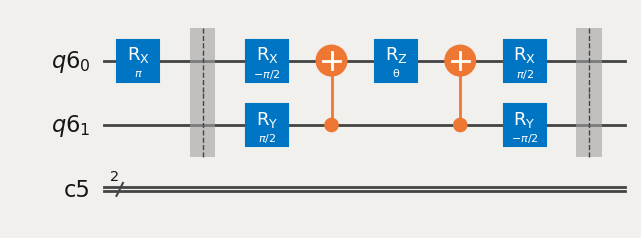

In [27]:
theta = Parameter("θ")
q = QuantumRegister(2)
c = ClassicalRegister(2)

ansatz_circuit = create_ansatz_circuit(q, c, theta)

ansatz_circuit.draw("mpl")

Barriers are added for visualization purposes. 

One of the new features added here is the $R_z$ gate with parameter $\theta$. This is a parametrized gate. Using this gate, this means that we only need to update the parameter $\theta$ and do not need to re-create the whole circuit, saving time. This becomes a problem when you have large circuits. 

Now we have:

1. The prepared initial state
2. The applied parameterized anzatz circuit

Now we need to measure the expectation values. However this is not straight forward.

## **Measure expectation values**

The qubit Hamiltonian we need to measure is as follows

$$ 
H = g_0 \mathbb{1} + g_1 Z_0 + g_2 Z_1 + g_3 Z_0 Z_1 + g_4 Y_0 Y_1 + g_5 X_0 X_1
$$

where $g_i$ are (real valued) coefficients that have been computed classically. They are given in the Table 1 in the appendix of O'Malley etal 2015. The values of $g_i$ are functions of hydrogen-hydrogen bond length $R$. We will take the coefficients at bond length $R = 0.75$ (in units $10^{-10}$ m) where the energy is lowest (the actual bond length where the energy is lowest is $0.74$, which is close).

Measurements are performed using the $Z$ basis through the Qiskit function `measure()`. This means that we cannot directly measure the Pauli $X$ or $Y$ operators for $X_0 X_1$ and $Y_0 Y_1$. In order to measure the latter, we have to use the following trick: 

- to measure $X$, perform basis transformation from the $X$ and $Z$
- then measure the qubits as usual (in the $Z$ basis) with `measure()`.

The same applies to $Y$ measurements, in this case we need to perform basis transformation from $Y$ to $Z$.

In order to compute the average value $\langle H \rangle$ of the (total) Hamiltonian we will use the fact that the total average is equal to the sum of averages of its terms,

$$
\langle H\rangle = g_0 \langle \mathbb{1}\rangle + g_1 \langle Z_0\rangle + g_2 \langle Z_1\rangle + g_3 \langle Z_0 Z_1\rangle + g_4 \langle Y_0 Y_1\rangle + g_5 \langle X_0 X_1\rangle.
$$

So we need to compute the expectation value of each term, then multiply each with the respective coefficient $g_i$, and finally add averages of all terms. Note that $\langle\mathbb{1}\rangle = 1$, so we can just add the coefficient $g_0$.

In [28]:
def paulis_to_measure_circ(qreg, creg, hamlist):
    """
    Generate measure circuits from hamiltonian pauli list
    for measurements in different bases.

    args
        qreg     - qubits
        creg     - classical bits
        hamlist  - total hamiltonian, i.e. pauli strings

    returns
        circuits - list of circuits that can be used to average over
    """
    circuits = []

    for elem in hamlist:
        minicirc = QuantumCircuit(qreg, creg)

        for qubitno, qubitop in elem:
            if qubitop == "Z":
                pass
            elif qubitop == "X":
                minicirc.h(qreg[qubitno])
            elif qubitop == "Y":
                minicirc.sdg(qreg[qubitno])
                minicirc.h(qreg[qubitno])
            else:
                assert False, "Error: INVALID qubit operation"

        minicirc.measure(qreg, creg)
        circuits.append(minicirc)

    return circuits

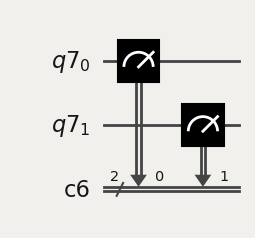

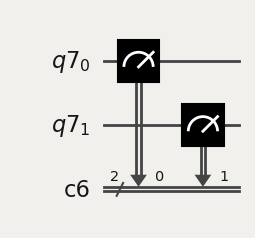

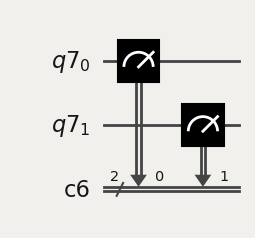

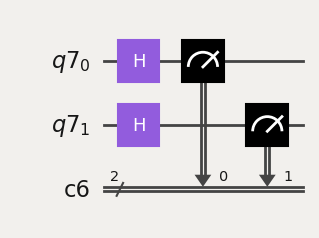

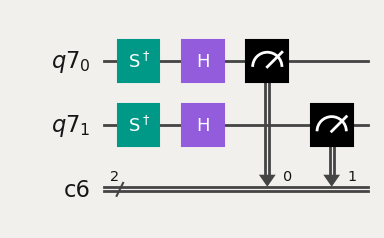

[None, None, None, None, None]

In [29]:
theta = Parameter("θ")
q = QuantumRegister(2)
c = ClassicalRegister(2)
hamiltonian = (
    ((0, "Z"),),
    ((1, "Z"),),
    ((0, "Z"), (1, "Z")),
    ((0, "X"), (1, "X")),
    ((0, "Y"), (1, "Y")),
)

ham_mini_circuits = paulis_to_measure_circ(q, c, hamiltonian)

# print result
[display(circ.draw("mpl")) for circ in ham_mini_circuits]

This function takes the qubit Hamiltonian and creates the corresponding circuits.  The smallest element has the form `(qubit_number, Pauli_matrix)`, where `qubit_number` is the index of the qubit for the Pauli observable.

Let's summarize the computation of the average of the Hamiltonian. We need to compute the averages of terms. We do this by looping over terms, which are represented as mini-circuits. For each mini-circuit, we will take the ansatz, add to it the mini-circuit, and run the resulting circuit, collect measurement statistics and compute the average.

## **Scan the parameter interval**

We will not bother with classical optimization in this small implementation. The circuit has only one parameter&mdash;the angle $\theta$ of the $R_z$ rotation&mdash;which ranges between $[-\pi, \pi]$. Instead of searching for the minimum value of $\langle H\rangle$, we will scan this interval and record the minimum energy.

Let us add a loop to do this.

In [41]:
def get_paulistr_avg(counts, obs, shots):
    """
    Calculate average of a Pauli string (e.g. IX, XX or YY).

    args
        counts      - result of simulation: {'00': 45, '01': 34, . . .}
        obs         - data for calculating probabilities
        shots       - number of repetitions

    returns
        avg         - the average value
    """
    avg = 0
    for c in counts:
        for k, v in c.items():
            avg += obs[k] * (v / shots)

    return avg


def get_ham_avg(
    theta, theta_range, ansatz, coeffs, ham_mini_circuits, obs, shots, backend
):
    """
    Compute average of the total qubit Hamiltonian.

    args
        params           - parameter value for the ansatz circuit
        ansatz           - ansatz circuit
        ham_mini_ciruits - pre-built circuits to measure Hamiltonian terms
        obs              - data for observables
        shots            - number of shots

    returns
        avg   - average of Hamiltonian
    """
    avg = 0

    for coeff, measure_circuit, obsval in zip(coeffs, ham_mini_circuits, obs):
        total_circuit = ansatz.compose(measure_circuit)
        qc_transpiled = transpile(
            total_circuit, backend=backend, layout_method="sabre", optimization_level=3
        )
        circuits = [qc_transpiled.assign_parameters({theta: n}) for n in theta_range]
        job = execute(circuits, backend, shots=shots)
        print(f"Submitted job ID: {job.job_id()}.")
        counts = job.result().get_counts()
        paulistring_avg = get_paulistr_avg(counts, obsval, shots)
        avg += coeff * paulistring_avg

    return avg

In [46]:
shots = 1000
num_points = 40
param_range = np.arange(-np.pi, np.pi, np.pi / num_points)

# record min val of hamiltonian
h_min = 100

# g_i coeffs for R = 0.75
# Source: Table I https://arxiv.org/pdf/1512.06860
g_coeff = [0.3435, -0.4347, 0.5716, 0.091, 0.091]
g_coeff_id = 0.2252

graph = []
obs = []

for x in param_range:
    h_avg = get_ham_avg(
        theta,
        param_range,
        ansatz_circuit,
        g_coeff,
        ham_mini_circuits,
        obs,
        shots,
        backend_sim,
    )
    print(h_avg)
    # h_avg += g_coeff_id        # add coeff of id term
    # graph.append(h_avg)        # collect data for plotting
    # if h_avg < h_min:           # record min value
    #     h_min = h_avg

# result
# print("\nH_min =", h_min)
print()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0



Here we loop through the interval defined in the parameter range, $[-\pi, \pi]$ and find the minimum energy. A value of $0.2252$ or $g_0$ is calculated as this code doesn't yet implement the averaging. We don't do any classical optimization here in this simple example but in principle we could add it here. 


## **Mapping outcome states to values**

To actually compute the average of a Hamiltonian term, we need to know how the outcomes of the measurement $00, 01, 10, 11$ that Qiskit uses correspond to the actual real valued outcomes $+1, -1$ for a particular observable like $Z_0$ or $Z_0 Z_1$ we measure. Without discussing this at length here, we are going to introduce dictionaries that record the mapping for each observable. Of course, there are other ways to implement this.

In [45]:
# map outcome states to outcome values
obs = [
    {"00": 1, "10": 1, "01": -1, "11": -1},  # 1 x Z
    {"00": 1, "10": -1, "01": 1, "11": -1},  # Z x 1
    {"00": 1, "10": -1, "01": -1, "11": 1},  # Z x Z
    {"00": 1, "10": -1, "01": -1, "11": 1},  # Y x Y
    {"00": 1, "10": -1, "01": -1, "11": 1},
]  # X x X

ansatz_circuit = create_ansatz_circuit(q, c, theta)
ham_mini_circuits = paulis_to_measure_circ(q, c, hamiltonian)


h_avg = get_ham_avg(
    theta,
    param_range,
    ansatz_circuit,
    g_coeff,
    ham_mini_circuits,
    obs,
    shots,
    backend_sim,
)

print(h_avg)

# scan theta domain [-pi, pi]
# for x in param_range:
#     h_avg += g_coeff_id        # add coeff of id term
#     graph.append(h_avg)        # collect data for plotting
#     if h_avg < h_min:           # record min value
#         h_min = h_avg

# print("\nH_min =", h_min)

Submitted job ID: 1ae76011-9adb-42ad-b480-427ff6f2716c.
Submitted job ID: 0295dbc3-0bfe-43a8-bce3-2dd40b35d5ff.
Submitted job ID: e8ff1f6b-b88d-4577-b417-98c5973d6d50.
Submitted job ID: b109bb78-28aa-4610-a6f7-a3b17fb6c00d.
Submitted job ID: d438f5fe-0e79-4d36-8303-5c12354ee49e.
-45.786435000000004


The function to get the hamiltonian average iterates over all of the mini circuits we created before. Each mini circuit is combined with the ansatz circuit, running it, collecting the statistics and computing the average for the term.

Also implemented is the function to calculate the Pauli string average energy. 

Running this code brings us a result that is close to the one obtained in the paper. It can be compared with Figure 3 with a Bond angle $R = 0.75$. 

<img src="img/lj-vqe-h2.png" alt="H2 energy curve. Source arXiv 1512.06860v2" title="H2 energu curve. Source arXiv 1512.06860v2" style="width: 700px;"/>

## **Using a pre-built function**

In [ ]:
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA

estimator = Estimator(options={"shots": 1000})


theta = Parameter("θ")
q = QuantumRegister(2)
c = ClassicalRegister(2)

ansatz_circuit = create_ansatz_circuit(q, c, theta)


optimizer = COBYLA(maxiter=1000)

In [ ]:
ansatz_circuit.draw("mpl")

In [ ]:
H2_op = SparsePauliOp.from_list(
    [
        ("II", 0.2252),
        ("IZ", 0.3435),
        ("ZI", -0.4347),
        ("ZZ", 0.5716),
        ("XX", 0.091),
        ("YY", 0.091),
    ]
)

In [ ]:
from qiskit_algorithms import VQE

vqe = VQE(estimator, ansatz_circuit, optimizer)
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)